In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')
from DEDi import ode_find as ode
from DEDi.ODE.PolyLib import *
import numpy as np
import matplotlib.pyplot as plt

### Colpitts Oscillator

Parameters: $(a, \nu, \gamma, q, a) = (5, 6.2723, 0.0797, 0.6898, -1)$

\begin{align}
    \frac{dx}{dt} &= a z \\
    \frac{dy}{dt} &= \nu \left( 1 - e^{ax} + z \right) \\
    \frac{dz}{dt} &= -\gamma(x + y) - q z
\end{align}

Size = (250, 3), dt = 0.2


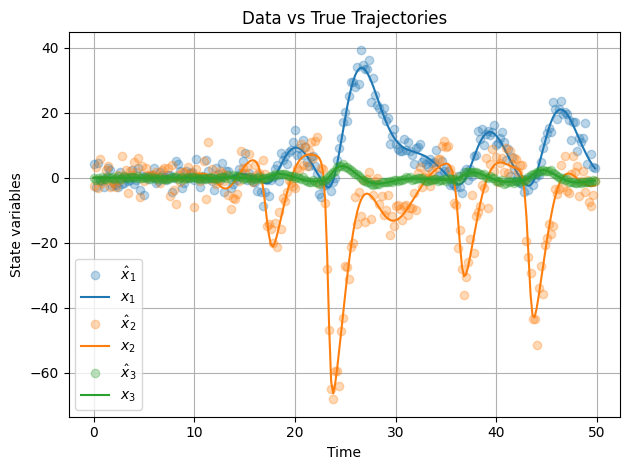

In [2]:
Data = np.load('../_ODEData/ColpittsData.npz')
x_data_true_full = Data['x']
t_full = Data['t']

np.random.seed(1)
subsample = 20
x_data_true = x_data_true_full[::subsample]
t = t_full[::subsample]

noise_p, stand_dev = .3, np.std(x_data_true, axis = 0)
x_data = x_data_true + np.random.normal(0,stand_dev*noise_p, size = x_data_true.shape)

# Define validation mask, standard is every third time (33% of data)
validation_mask = np.ones_like(x_data, dtype=bool)
validation_mask[2::3] = False

print(f'Size = {np.shape(x_data)}, dt = {t[1]-t[0]}')
from DEDi.plot_trajectories import plot_trajectory
plot_trajectory(t,x_data,x_data_true)

In [3]:
Library = PolyFunc(num_vars=x_data.shape[1],degree=2,constant=True, custom = ['exp(p*x_1)'])
print(Library)
discoverode = ode(x_data, Library, [t[0], t[-1]], validation_mask=validation_mask, rescale_states=True)

['1', 'x_1', 'x_2', 'x_3', 'x_1**2', 'x_1*x_2', 'x_1*x_3', 'x_2**2', 'x_2*x_3', 'x_3**2', 'exp(p1*x_1)']
Setting up Sparse Hessian
Colors Needed = 45


In [4]:
# Initialize Library & Model Discovery
# lambdas,Rs  = 10**(np.linspace(-3, 3, 7)),10**(np.linspace(-4, 0, 5))  #Parameters used in paper, better to try a simple run first 
lambdas = [1e-2]
Rs = [1e-2]
discoverode.FindBestModel(lambdas, Rs)

[Failed to Converged] Iter 500: ||grad|| = 3.90e-02
[Failed to Converged] Iter 500: ||grad|| = 2.39e-02
[Failed to Converged] Iter 500: ||grad|| = 8.92e-03
[Failed to Converged] Iter 500: ||grad|| = 9.25e-03
lam = 1.00e-02, R = 1.00e-02, nonzero = 7, val_error = 8.4584e-02,BIC = -5.76e+02, model_error = 4.2044e-06, state_error = 7.7340e-02


In [5]:
FullModels = discoverode.PrintModels(N_best=5) #Max models to print is number of combinations of hyperparameters used. 

<IPython.core.display.Latex object>

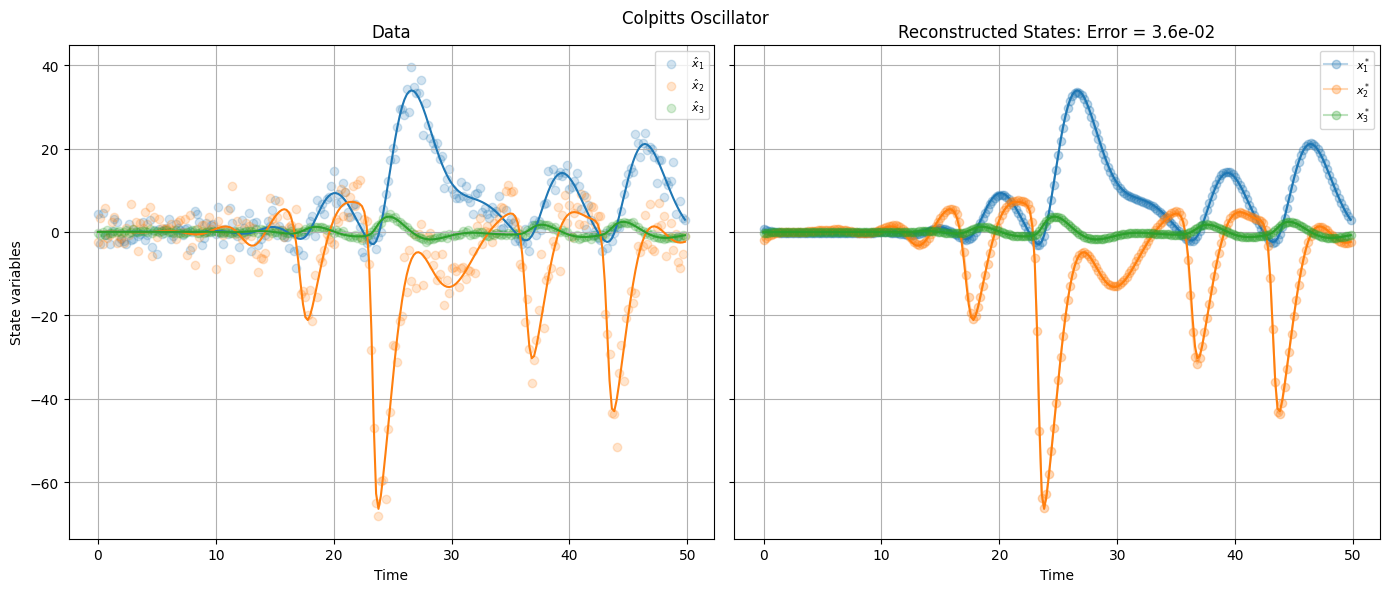

In [6]:
opt_params, opt_NL_params, opt_states = discoverode.best_model()

from DEDi.plot_trajectories import plot_solution
plot_solution(t,x_data,opt_states,x_data_true, title= "Colpitts Oscillator")

In [7]:
### Need to do some extra stuff here to compute errors due to nonlinear terms 

from _ODEData.Functions.ODEFuncs import generate_coeff_matrix, getcolpittscoeffs, Report_Errors
# Extract model and compare with ground truth
true_coeffs = generate_coeff_matrix(Library, getcolpittscoeffs())
true_state_error = np.linalg.norm(opt_states - x_data_true) / np.linalg.norm(x_data_true)

### NEED TO INCLUDE NL PARAMS IN CALCULATION
Linear_param_flag = [("p" in term) for term in discoverode.library] #False if params are linear
N_nlparams = np.sum(Linear_param_flag) #Check how many nonlinear parameters
NL_Leading_ceoffs = opt_params[-N_nlparams:]
NL_multiplier = np.sum(NL_Leading_ceoffs, axis = 1).astype(bool).astype(int) #Checks if the leading linear coefficient is nonzero
NL_params_Result = NL_multiplier*opt_NL_params #Only evaluate if linear coefficient is nonzero

true_NL_params = np.zeros_like(NL_params_Result) #Create true coefficeints  (Should update based on library)
true_NL_params[0] = -1

found_params = np.concatenate((opt_params.flatten(),NL_params_Result))
true_params = np.concatenate((true_coeffs.flatten(),true_NL_params))

L2_error, LInf_error, true_positivity_ratio = Report_Errors(true_params, found_params)

print(f"L2 Error = {L2_error:.3e}, LInf Error = {LInf_error:.3e}, TPR = {int(true_positivity_ratio*100)}%")

L2 Error = 1.278e-01, LInf Error = 2.442e-01, TPR = 100%
